# Модели машинного обучения для предсказания уровня удовлетворённости сотрудников и  предсказания увольнений сотрудников компании

**Исходные данные**, предоставленные компанией, содержат характеристи сотрудников компании, в том числе уровень удовлетворённости сотрудника работой в компании. Информация получена из форм обратной связи: заполненных сотрудниками тест-опросников, по которым рассчитана доля их удовлетворённости от 0 до 1, где 0 — совершенно неудовлетворён, 1 — полностью удовлетворён. 

**Цель исследования** - разработать модели машинного обучения, предсказывающие уровень удовлетворённости сотрудников и вероятность увольнения сотрудников компании, что позволит компании оптимизировать управление персоналом в целях снижения финансовых потерь и оттока сотрудников.

**Этапы**:
1. Построить модель для предсказания уровня удовлетворённости сотрудника на основе данных заказчика.
2. Построить модель для предсказания на основе исходных данных увольнение сотрудника из компании.

In [1]:
# установка библиотек:
! pip install -U scikit-learn -q
! pip install shap -q
! pip install phik -q

In [2]:
# импорт необходимых библиотек:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
# загрузка классов для подготовки данных
from sklearn.preprocessing import (
    OneHotEncoder,
    OrdinalEncoder, 
    StandardScaler, 
    MinMaxScaler,
    RobustScaler,
    LabelEncoder
)
from sklearn.compose import ColumnTransformer
# загрузка классов для работы с пропусками
from sklearn.impute import SimpleImputer
# загрузка функции для работы с метриками
from sklearn.metrics import f1_score, roc_auc_score, make_scorer
# импорт класса RandomizedSearchCV
from sklearn.model_selection import GridSearchCV
# загрузка моделей
from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn.tree import DecisionTreeRegressor, DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC

import shap

from phik import phik_matrix
from phik.report import plot_correlation_matrix

## Предсказание уровня удовлетворённости сотрудника.

Удовлетворённость работой напрямую влияет на отток сотрудников, предсказание оттока уменьшит вероятность внезапных увольнений, которые несут в себе риски для компании.

### Импорт и предобработка  данных.

In [3]:
# данные файла "train_job_satisfaction_rate.csv":
train = pd.read_csv ('/datasets/train_job_satisfaction_rate.csv')
print (train.info())
print ()
print ('Наименования столбцов: ', train.columns)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4000 entries, 0 to 3999
Data columns (total 10 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   id                     4000 non-null   int64  
 1   dept                   3994 non-null   object 
 2   level                  3996 non-null   object 
 3   workload               4000 non-null   object 
 4   employment_years       4000 non-null   int64  
 5   last_year_promo        4000 non-null   object 
 6   last_year_violations   4000 non-null   object 
 7   supervisor_evaluation  4000 non-null   int64  
 8   salary                 4000 non-null   int64  
 9   job_satisfaction_rate  4000 non-null   float64
dtypes: float64(1), int64(4), object(5)
memory usage: 312.6+ KB
None

Наименования столбцов:  Index(['id', 'dept', 'level', 'workload', 'employment_years',
       'last_year_promo', 'last_year_violations', 'supervisor_evaluation',
       'salary', 'job_satisfaction_rat

In [4]:
# посмотрим на строки, содержащие пропуски
train[train['dept'].isna() | train['level'].isna()]

,id,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary,job_satisfaction_rate
1209,631073,sales,NaN,medium,1,no,no,4,27600,0.66
1469,416327,sales,NaN,low,1,no,no,5,18000,0.73
1526,694746,NaN,junior,medium,5,no,no,4,21600,0.62
1630,814624,NaN,junior,medium,3,no,no,4,24000,0.88
1633,475114,NaN,junior,high,4,no,no,4,31200,0.63
1745,135043,sales,NaN,medium,1,no,no,3,26400,0.30
2522,998838,sales,NaN,medium,1,no,no,5,27600,0.71
2781,497243,NaN,junior,medium,1,no,no,3,26400,0.28
2975,168668,NaN,junior,low,3,no,no,4,18000,0.88
3866,641150,NaN,junior,low,3,no,yes,4,12000,0.54


In [5]:
# данные файла "train_job_satisfaction_rate.csv" и "test_target_job_satisfaction_rate":
test_features = pd.read_csv ('/datasets/test_features.csv')
test_target = pd.read_csv ('/datasets/test_target_job_satisfaction_rate.csv')
test = test_features.merge (test_target, on = 'id', how = 'inner')
print (test.info())
print ()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2000 entries, 0 to 1999
Data columns (total 10 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   id                     2000 non-null   int64  
 1   dept                   1998 non-null   object 
 2   level                  1999 non-null   object 
 3   workload               2000 non-null   object 
 4   employment_years       2000 non-null   int64  
 5   last_year_promo        2000 non-null   object 
 6   last_year_violations   2000 non-null   object 
 7   supervisor_evaluation  2000 non-null   int64  
 8   salary                 2000 non-null   int64  
 9   job_satisfaction_rate  2000 non-null   float64
dtypes: float64(1), int64(4), object(5)
memory usage: 171.9+ KB
None



In [6]:
# в тестовых данных также присутствуют пропуски
test[test['dept'].isna() | test['level'].isna()]

,id,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary,job_satisfaction_rate
191,609865,NaN,junior,medium,1,no,no,1,20400,0.12
312,471990,sales,NaN,low,1,no,no,3,12000,0.17
1196,832342,NaN,junior,medium,1,no,no,4,28800,0.61


Заполним пропуски в данных. Так как признаки с пропусками - категориальные, логичнее использовать самое частотное значение в выборке.

In [7]:
simple_imputer = SimpleImputer(strategy='most_frequent')
pipe_si = Pipeline([('imputer', simple_imputer)])
train['dept'] = pipe_si.fit_transform(train[['dept']])
train['level'] = pipe_si.fit_transform(train[['level']])
train.loc[[1209, 1526]]

,id,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary,job_satisfaction_rate
1209,631073,sales,junior,medium,1,no,no,4,27600,0.66
1526,694746,sales,junior,medium,5,no,no,4,21600,0.62


In [8]:
test['dept'] = pipe_si.fit(train[['dept']]).transform(test[['dept']])
test['level'] = pipe_si.fit(train[['level']]).transform(test[['level']])
test.loc[[191, 312, 1196]]

,id,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary,job_satisfaction_rate
191,609865,sales,junior,medium,1,no,no,1,20400,0.12
312,471990,sales,junior,low,1,no,no,3,12000,0.17
1196,832342,sales,junior,medium,1,no,no,4,28800,0.61


Пропуски в тренировочных и тестовых данных заменены на наиболее часто встречающееся значение.

In [9]:
# проверим данные на наличие дубликатов:
print ('Кол-во дубликатов в тренировочных данных: ', train.duplicated().sum())
print ('Кол-во дубликатов в тестовых данных: ', test.duplicated().sum())

Кол-во дубликатов в тренировочных данных:  0
Кол-во дубликатов в тестовых данных:  0


Явные дубликаты отсутствуют. Исследуем уникальные значения строковых признаков.

In [10]:
# ['dept', 'level', 'workload', 'last_year_promo', 'last_year_violations']
cat_col = train.select_dtypes(include=['object']).columns.to_list()
for col in cat_col: 
    print(f'Значения столбца тренировочной выборки {col}: {train[col].unique()}')
print()
for col in cat_col: 
    print(f'Значения столбца тестовой выборки {col}: {test[col].unique()}')


Значения столбца тренировочной выборки dept: ['sales' 'hr' 'technology' 'purchasing' 'marketing']
Значения столбца тренировочной выборки level: ['junior' 'middle' 'sinior']
Значения столбца тренировочной выборки workload: ['medium' 'high' 'low']
Значения столбца тренировочной выборки last_year_promo: ['no' 'yes']
Значения столбца тренировочной выборки last_year_violations: ['no' 'yes']

Значения столбца тестовой выборки dept: ['marketing' 'hr' 'sales' 'purchasing' 'technology' ' ']
Значения столбца тестовой выборки level: ['junior' 'middle' 'sinior']
Значения столбца тестовой выборки workload: ['medium' 'low' 'high' ' ']
Значения столбца тестовой выборки last_year_promo: ['no' 'yes']
Значения столбца тестовой выборки last_year_violations: ['no' 'yes']


Неявные дубликаты также отсутствуют. Но в тестовой выборке есть пустые значения в столбце "dept" и "workload".

In [11]:
test[~test['dept'].isin(['marketing', 'hr', 'sales', 'purchasing', 'technology'])]

,id,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary,job_satisfaction_rate
1699,822186,,middle,medium,3,no,no,4,38400,0.64


In [12]:
test[~test['workload'].isin(['medium', 'low', 'high'])]

,id,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary,job_satisfaction_rate
15,590867,marketing,junior,,4,no,no,4,28800,0.79


Обнаружилось по одному пустому значению в каждом признаке - заполним их на этапе кодирования данных.

### Исследовательский анализ данных.

Исследуем признаки.

#### Распределение сотрудников по категориальным признакам

'Размер данных: (6000, 10)'

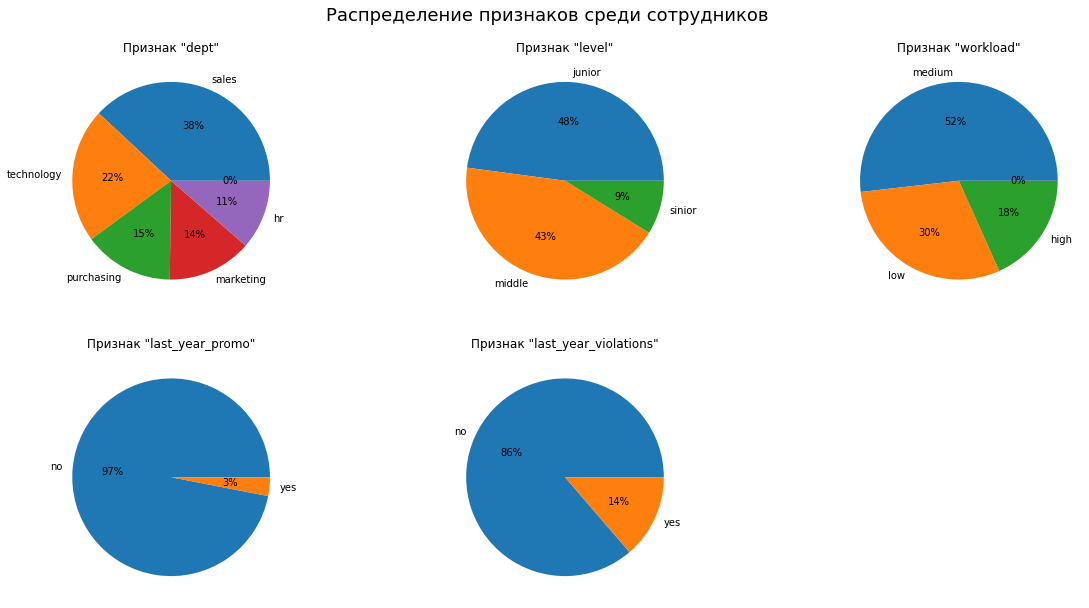

In [13]:
train_test = pd.concat([train, test])
display(f'Размер данных: {train_test.shape}')
plt.figure(figsize=(20, 10))
plt.suptitle('Распределение признаков среди сотрудников', fontsize=18, y=0.95)
#plt.subplots_adjust(hspace=0.2)
#axe = axes.ravel()
for index, i in enumerate(cat_col):
    ax = plt.subplot(round(len(cat_col)/3), 3, index + 1)
    train_test[i].value_counts().plot(kind='pie', autopct='%1.0f%%', ax = ax, 
                                      title=f'Признак "{i}"', ylabel='')

Графики показывают, что:
- большая часть сотрудников (38%) работают в отделе продаж, на втором месте (22%) - IT;
- больше всего сотрудников на позиции junior (48%), сотрудников среднего звена - 43% и старших сотрудников - 9%;
- 52 % сотрудников имеют средний уровень загруженности (workload), 30% - низкую и 18% - высокую;
- повышение за последний год (last_year_promo) получили 3 % сотрудников;
- 14% сотрудников нарушали трудовой договор за последний год.

***Сравнение распределения признаков на тренировочных и тестовых данных:***

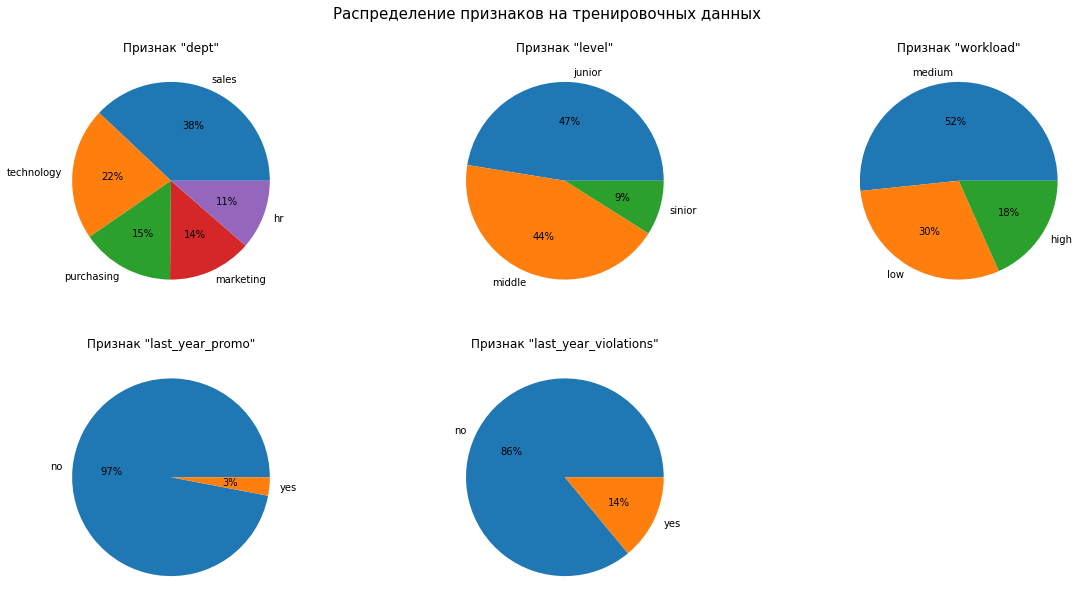

In [14]:
plt.figure(figsize=(20, 10))
plt.suptitle('Распределение признаков на тренировочных данных', fontsize=15, y=0.95)
for index, i in enumerate(cat_col):
    ax = plt.subplot(round(len(cat_col)/3), 3, index + 1)
    train[i].value_counts().plot(kind='pie', autopct='%1.0f%%', ax = ax, title=f'Признак "{i}"', ylabel='')

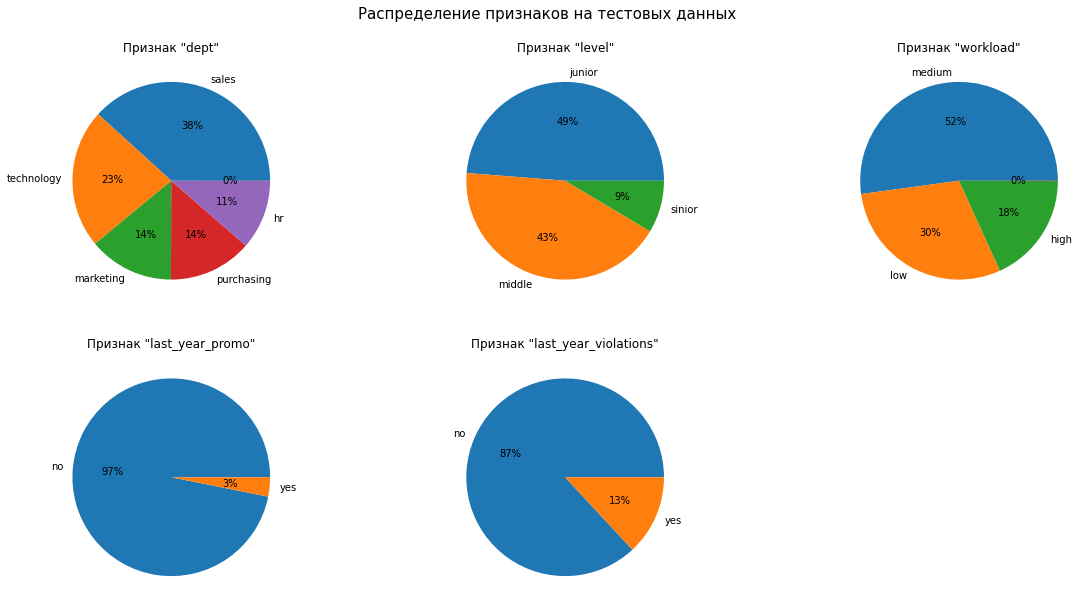

In [15]:
plt.figure(figsize=(20, 10))
plt.suptitle('Распределение признаков на тестовых данных', fontsize=15, y=0.95)
for index, i in enumerate(cat_col):
    ax1 = plt.subplot(round(len(cat_col)/3), 3, index + 1)
    test[i].value_counts().plot(kind='pie', autopct='%1.0f%%', ax = ax1, 
                                    title=f'Признак "{i}"', ylabel='')

Сравнение распределения категориальных признаков на тестовых и тренировочных данных не выявило сильных различий: распределение признаков 'workload' и 'last_year_promo' идентично, разница распределения признаков 'dept', 'level' и 'last_year_violations' в пределах 1-2%.

#### Распределение сотрудников по количественным признакам

In [16]:
num_сol = train_test.select_dtypes(include=['number']).columns.to_list()
print (num_сol)

['id', 'employment_years', 'supervisor_evaluation', 'salary', 'job_satisfaction_rate']


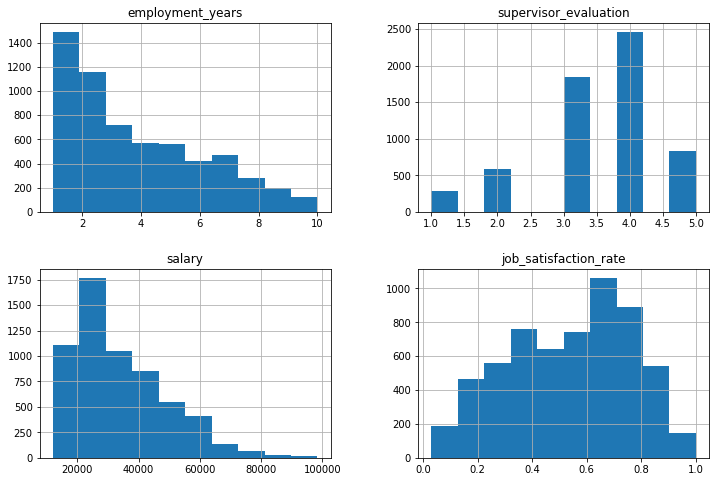

In [17]:
train_test.drop('id', axis=1).hist(bins=10, figsize=(12, 8));

Выбросы и аномалиии в числовых данных не наблюдаются.

In [18]:
#посмотрим на описание числовых признаков
train_test.drop('id', axis=1).describe()

,employment_years,supervisor_evaluation,salary,job_satisfaction_rate
count,6000.000000,6000.000000,6000.000000,6000.000000
mean,3.701167,3.493167,33973.400000,0.538923
std,2.540658,1.005048,15067.302669,0.223692
min,1.000000,1.000000,12000.000000,0.030000
25%,2.000000,3.000000,22800.000000,0.360000
50%,3.000000,4.000000,30000.000000,0.570000
75%,6.000000,4.000000,43200.000000,0.710000
max,10.000000,5.000000,98400.000000,1.000000


Исходя из графиков и описательной статистики количественных показателей:
- сотрудники работают в компании от 1 до 10 лет, в среднем длительность работы в компании (employment_years) составляет 3,7 года;
- средняя оценка качества работы сотрудников руководителем (supervisor_evaluation) равна 3,5 по 5-балльной шкале;
- средняя зарплата (salary) сотрудников составляет около  34 тыс.руб. (от 12 тыс. руб. до 98 400 тыс. руб.), при этом половина сотрудников получает 30 тыс.руб. и менее, 25 % сотрудников получают 43,2 тыс. руб. и выше;
- уровень удовлетворённости сотрудника работой в компании (job_satisfaction_rate) принимает значение от 0 до 1, среднее значение целевого признака job_satisfaction_rate = 0,54.

***Сравнение распределения числовых признаков на тренировочных и тестовых данных:***

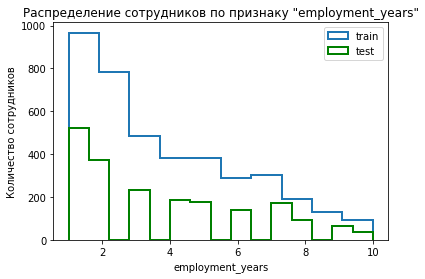

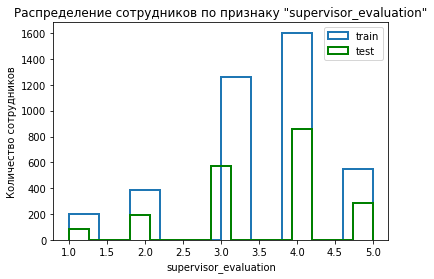

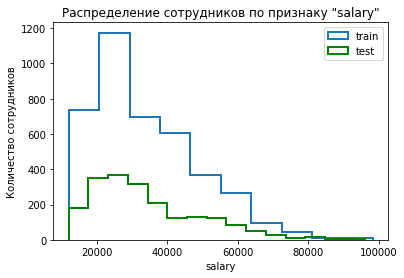

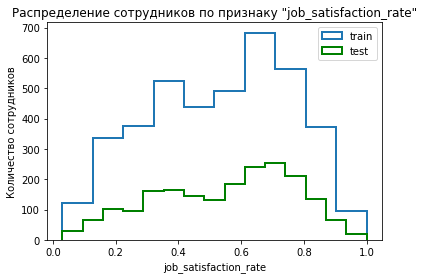

In [19]:
for i in num_сol [1:]:
    ax = train.plot(kind='hist', y = i, histtype='step', linewidth=2, label='train', grid=True, legend=True)
    test.plot(kind='hist', y = i, histtype='step', ax=ax, bins=15, color='green', linewidth=2, label='test', legend=True)
    plt.title(f'Распределение сотрудников по признаку "{i}"')
    plt.xlabel(i)
    plt.ylabel('Количество сотрудников')
    plt.show()

Числовые признаки также имеют схожее распределение в тестовых и тренировочных данных.

### Корреляционных анализ данных.

Посмотрим на влияние признаков на целевой признак и друг на друга:

interval columns not set, guessing: ['employment_years', 'supervisor_evaluation', 'salary', 'job_satisfaction_rate']


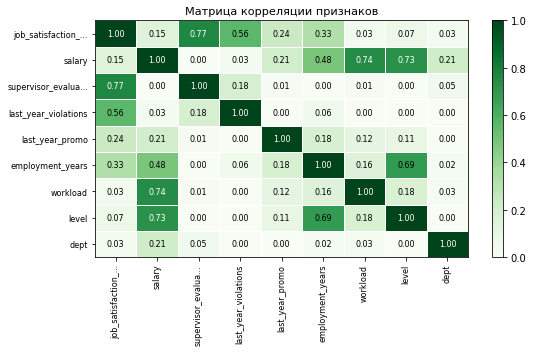

In [20]:
phik_overview = phik_matrix(train_test.drop('id', axis=1))
plot_correlation_matrix(
    phik_overview.values,
    x_labels=phik_overview.columns,
    y_labels=phik_overview.index,
    vmin=0, vmax=1, color_map='Greens',
    title=r'Матрица корреляции признаков',
    fontsize_factor=0.8,
    figsize=(8, 5)
) 

Мультиколлинеарность (значения коэффициентов корреляции от 0.9 до 0.95 по модулю) входных признаков не наблюдается. На целевой признак уровня удовлетворённости сотрудника работой в компании (job_satisfaction_rate) наибольшее влияние оказывает оценка качества работы сотрудника, которую дал руководитель (supervisor_evaluation), также заметное влияние оказывают нарушения сотрудниками трудового договора (last_year_violations) и длительность работы в компании (employment_years). Слабое влияние на уровнень удовлетворённости сотрудников имеют размер ежемесячной зарплаты (salary) и повышения за последний год (last_year_promo). И практически не влияют на уровень удовлетворённости сотрудников уровень их загруженности (workload), отдел, в котором они работают, (dept) и уровень занимаемой должности (level).

### Подготовка данных.

Создадим пайплайны для кодирования категориальных признаков и масштабирования количественных.

In [21]:
# разделим столбцы на подходящие им типы кодирования
num_сol = ['employment_years', 'supervisor_evaluation', 'salary']
ohe_col = ['last_year_promo', 'last_year_violations', 'dept']
ord_col = ['level', 'workload']

In [22]:
# создаём пайплайн для подготовки признаков из списка ohe_columns: 
ohe_pipe = Pipeline(
    [('simpleImputer_ohe', SimpleImputer(missing_values=np.nan, strategy='most_frequent')),
     ('ohe', OneHotEncoder(drop='first', handle_unknown='ignore'))]

)
# создаём пайплайн для подготовки признаков из списка ord_columns: 
ord_pipe = Pipeline(
    [('simpleImputer_before_ord', SimpleImputer(missing_values=np.nan, strategy='most_frequent')),
     ('ord',  OrdinalEncoder(
                categories=[
                    ['junior', 'middle', 'sinior'],
                    ['low', 'medium', 'high'],
                    
                ], 
                handle_unknown='use_encoded_value', unknown_value=np.nan
            )
        ),
     ('simpleImputer_after_ord', SimpleImputer(missing_values=np.nan, strategy='most_frequent'))
    ]
)

In [23]:
# создаём общий пайплайн для подготовки данных
data_preprocessor = ColumnTransformer(
    [('ohe', ohe_pipe, ohe_col),
     ('ord', ord_pipe, ord_col),
     ('num', MinMaxScaler(), num_сol)
    ], 
    remainder='passthrough'
)

Проверим появятся ли дубликаты в тренировочных данных после удаления столбца 'id':

In [24]:
train.drop(['id'], axis = 1).duplicated().sum()

248

Очистим тренировочную выборку от дубликатов без учета 'id':

In [25]:
train = train.drop(['id'], axis = 1).drop_duplicates()
print(f'После удаления размер тренировочной выборки составляет {train.shape[0]} строки.')

После удаления размер тренировочной выборки составляет 3752 строки.


In [26]:
# выделим из тренировочной и тестовой входные признаки и целевой признак:
X_train = train.drop(['job_satisfaction_rate'], axis = 1)
y_train = pd.Series(train['job_satisfaction_rate'])
X_test = test.drop(['job_satisfaction_rate', 'id'], axis = 1)
y_test = pd.Series(test['job_satisfaction_rate'])

### Обучение моделей.

In [27]:
# зададим константу
RANDOM_STATE = 42

Выбирать лучшую модель и проверять её качество будем на основе метрики SMAPE («симметричное среднее абсолютное процентное отклонение»). Для этого создадим эту метрику:

In [28]:
def SMAPE (y_true, y_pred):
    dif = np.abs(y_true - y_pred)
    avg = (np.abs(y_true) + np.abs(y_pred))/2
    return np.mean(dif/avg)*100
scorer = make_scorer(SMAPE, greater_is_better = False)

#### Модель линейной регрессии.

In [29]:
# создаём пайплайн для обучения модели линейной регрессии: 
pipe_linal = Pipeline([
    ('preprocessor', data_preprocessor),
    ('models', LinearRegression())
])

param_grid_linal = [
    # словарь для модели LinearRegression()
    {
        'models': [LinearRegression()],
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), RobustScaler(), 'passthrough']  
    }
]

In [30]:
# подберем лучшие параметры для линейной регрессии:
grid_linal = GridSearchCV(
    pipe_linal, 
    param_grid_linal, 
    cv=5,
    scoring=scorer,
    n_jobs=-1
)
grid_linal.fit(X_train, y_train)

print('Лучшие параметры модели линейной регрессии:\n\n', grid_linal.best_estimator_)
print ('Метрика лучшей модели линейной регрессии на тренировочной выборке:', np.abs(grid_linal.best_score_))

# на тестовой выборке
y_test_pred = grid_linal.predict(X_test)
print(f'Метрика SMAPE на тестовых данных: {SMAPE(y_test, y_test_pred)}');


Лучшие параметры модели линейной регрессии:

 Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('ohe',
                                                  Pipeline(steps=[('simpleImputer_ohe',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('ohe',
                                                                   OneHotEncoder(drop='first',
                                                                                 handle_unknown='ignore'))]),
                                                  ['last_year_promo',
                                                   'last_year_violations',
                                                   'dept']),
                                                 ('ord',
                                                  Pipeline(steps=

/opt/conda/lib/python3.9/site-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [2] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


#### Модель регрессии дерева решений.

In [31]:
# создаём пайплайн для обучения модели дерева регрессии: 
pipe_tree = Pipeline([
    ('preprocessor', data_preprocessor),
    ('models', DecisionTreeRegressor(random_state=RANDOM_STATE))
])

param_grid_tree = [
    # словарь для модели DecisionTreeRegressor()
    {
        'models': [DecisionTreeRegressor(random_state=RANDOM_STATE)],
        'models__max_depth': range(5, 15),
        'models__max_features': range(1, 15),
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), RobustScaler(), 'passthrough']  
    }
]

In [32]:
# подберем лучшие параметры для дерева регрессии:
grid_tree = GridSearchCV(
    pipe_tree, 
    param_grid_tree, 
    cv=5,
    scoring=scorer,
    n_jobs=-1
)
grid_tree.fit(X_train, y_train)

print('Лучшие параметры модели дерева регрессии:\n\n', grid_tree.best_estimator_)
print ('Метрика лучшей модели дерева регрессии на тренировочной выборке:', np.abs(grid_tree.best_score_))

# на тестовой выборке
y_test_pred = grid_tree.predict(X_test)
print(f'Метрика SMAPE на тестовых данных: {SMAPE(y_test, y_test_pred)}');

Лучшие параметры модели дерева регрессии:

 Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('ohe',
                                                  Pipeline(steps=[('simpleImputer_ohe',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('ohe',
                                                                   OneHotEncoder(drop='first',
                                                                                 handle_unknown='ignore'))]),
                                                  ['last_year_promo',
                                                   'last_year_violations',
                                                   'dept']),
                                                 ('ord',
                                                  Pipeline(steps=[(

/opt/conda/lib/python3.9/site-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [2] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


### Вывод о модели уровня удовлетворенности сотрудника.

Лучшие показатели прогнозирования уровня удовлетворенности сотрудников - у модели дерева регрессии с глубиной = 11 и 10 учитываемыми признаками.

## Предсказание вероятности увольнения сотрудника.

Модель № 2 будет предсказывать факт увольнения сотрудника.

### Импорт и предобработка  данных.

In [33]:
# данные файла "train_job_satisfaction_rate.csv":
train2 = pd.read_csv ('/datasets/train_quit.csv')
print (train2.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4000 entries, 0 to 3999
Data columns (total 10 columns):
 #   Column                 Non-Null Count  Dtype 
---  ------                 --------------  ----- 
 0   id                     4000 non-null   int64 
 1   dept                   4000 non-null   object
 2   level                  4000 non-null   object
 3   workload               4000 non-null   object
 4   employment_years       4000 non-null   int64 
 5   last_year_promo        4000 non-null   object
 6   last_year_violations   4000 non-null   object
 7   supervisor_evaluation  4000 non-null   int64 
 8   salary                 4000 non-null   int64 
 9   quit                   4000 non-null   object
dtypes: int64(4), object(6)
memory usage: 312.6+ KB
None


Данные второй тренировочной выборки не содержат пропусков.

In [34]:
# данные файла "test_features.csv" и "test_target_quit.csv":
test_features2 = pd.read_csv ('/datasets/test_features.csv')
test_target2 = pd.read_csv ('/datasets/test_target_quit.csv')
test2 = test_features.merge (test_target2, on = 'id', how = 'inner')
print (test2.info())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2000 entries, 0 to 1999
Data columns (total 10 columns):
 #   Column                 Non-Null Count  Dtype 
---  ------                 --------------  ----- 
 0   id                     2000 non-null   int64 
 1   dept                   1998 non-null   object
 2   level                  1999 non-null   object
 3   workload               2000 non-null   object
 4   employment_years       2000 non-null   int64 
 5   last_year_promo        2000 non-null   object
 6   last_year_violations   2000 non-null   object
 7   supervisor_evaluation  2000 non-null   int64 
 8   salary                 2000 non-null   int64 
 9   quit                   2000 non-null   object
dtypes: int64(4), object(6)
memory usage: 171.9+ KB
None


In [35]:
# в тестовых данных присутствуют пропуски
test2[test2['dept'].isna() | test2['level'].isna()]

,id,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary,quit
191,609865,NaN,junior,medium,1,no,no,1,20400,yes
312,471990,sales,NaN,low,1,no,no,3,12000,yes
1196,832342,NaN,junior,medium,1,no,no,4,28800,no


Заполним пропуски в данных при моделировании.

In [36]:
# проверим данные на наличие дубликатов:
print ('Кол-во дубликатов в тренировочных данных: ', train2.duplicated().sum())
print ('Кол-во дубликатов в тестовых данных: ', test2.duplicated().sum())

Кол-во дубликатов в тренировочных данных:  0
Кол-во дубликатов в тестовых данных:  0


In [37]:
cat_col = train2.select_dtypes(include=['object']).columns.to_list()
for col in cat_col: 
    print(f'Значения столбца тренировочной выборки {col}: {train2[col].unique()}')
print()
for col in cat_col: 
    print(f'Значения столбца тестовой выборки {col}: {test2[col].unique()}')

Значения столбца тренировочной выборки dept: ['sales' 'purchasing' 'marketing' 'technology' 'hr']
Значения столбца тренировочной выборки level: ['middle' 'junior' 'sinior']
Значения столбца тренировочной выборки workload: ['high' 'medium' 'low']
Значения столбца тренировочной выборки last_year_promo: ['no' 'yes']
Значения столбца тренировочной выборки last_year_violations: ['no' 'yes']
Значения столбца тренировочной выборки quit: ['no' 'yes']

Значения столбца тестовой выборки dept: ['marketing' 'hr' 'sales' 'purchasing' 'technology' nan ' ']
Значения столбца тестовой выборки level: ['junior' 'middle' 'sinior' nan]
Значения столбца тестовой выборки workload: ['medium' 'low' 'high' ' ']
Значения столбца тестовой выборки last_year_promo: ['no' 'yes']
Значения столбца тестовой выборки last_year_violations: ['no' 'yes']
Значения столбца тестовой выборки quit: ['no' 'yes']


In [38]:
test2[~test2['dept'].isin(['marketing', 'hr', 'sales', 'purchasing', 'technology'])]

,id,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary,quit
191,609865,NaN,junior,medium,1,no,no,1,20400,yes
1196,832342,NaN,junior,medium,1,no,no,4,28800,no
1699,822186,,middle,medium,3,no,no,4,38400,no


In [39]:
test2[~test2['workload'].isin(['medium', 'low', 'high'])]

,id,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary,quit
15,590867,marketing,junior,,4,no,no,4,28800,no


Пропуски и пустые значения наблюдаются в признаках "dept", "level" и "workload". Опечаток в данных нет. Т.к. количество некорректно заполненных данных незначительно, то они не скажутся на результатах исследователького анализа, поэтому их обработаем на этапе моделирования.

### Исследовательский анализ данных.

Посмотрим на распределение сотрудников по их статусу (действующий - no или уволен - yes):

In [40]:
train_test2 = pd.concat([train2, test2])
print (train_test2 ['quit'].value_counts())

no     4308
yes    1692
Name: quit, dtype: int64


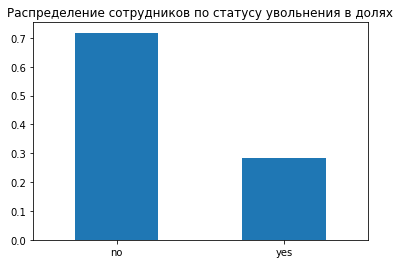

In [41]:
train_test2 ['quit'].value_counts(normalize=True).plot(kind='bar', rot = 0, title = 'Распределение сотрудников по статусу увольнения в долях'); 

Почти 30 % сотрудников увольняется. Посмотрим на отличительные признаки этого сегмента сотрудников:

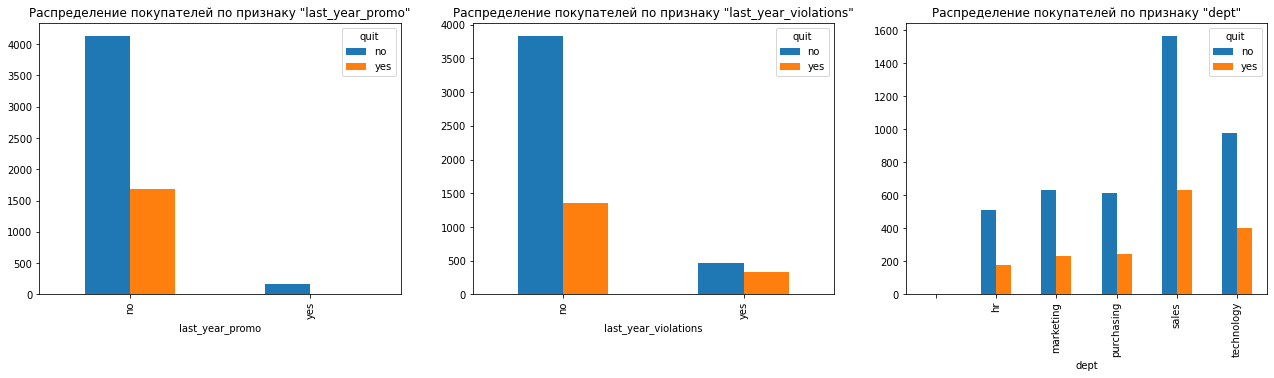

In [42]:
# распределение по категориальным признакам
fig, ax = plt.subplots(1, len(ohe_col), figsize=(22, 5))
for index, i in enumerate(ohe_col):
    train_test2.pivot_table (columns = 'quit', index = i, values = 'salary', 
                        aggfunc='count').plot(kind='bar', ax = ax [index],
                                              title=f'Распределение покупателей по признаку "{i}"')

Уволившиеся сотрудники также получали повышение за последний год (last_year_promo) как и оставшиеся работать, а вот доля сотрудников, нарушавших условия трудового договора за последний год, среди уволившихся сотрудников меньше.

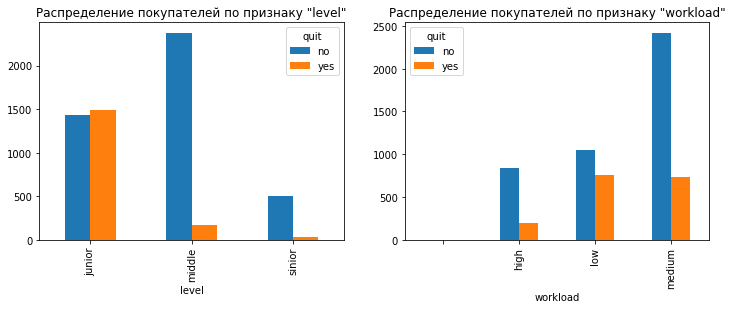

In [43]:
# распределение по категориальным признакам
fig, ax = plt.subplots(1, len(ord_col), figsize=(12, 4))
for index, i in enumerate(ord_col):
    train_test2.pivot_table (columns = 'quit', index = i, values = 'salary', 
                        aggfunc='count').plot(kind='bar', ax = ax [index], 
                                              title=f'Распределение покупателей по признаку "{i}"')

Доли уволившихся в разных департаментах (dept) примерно одинаковы. Сотрудники среднего (middle) и высшего (sinior) звена увольняются гораздо чаще, чем сотрудники с маленьким опытом (junior). Также доля уволившихся сотрудников с высоким и средним уровнем загруженности (workload) на работе выше, чем у слабозагруженных сотрудников.


***Распределение категориальных признаков среди сотрудников в долях***

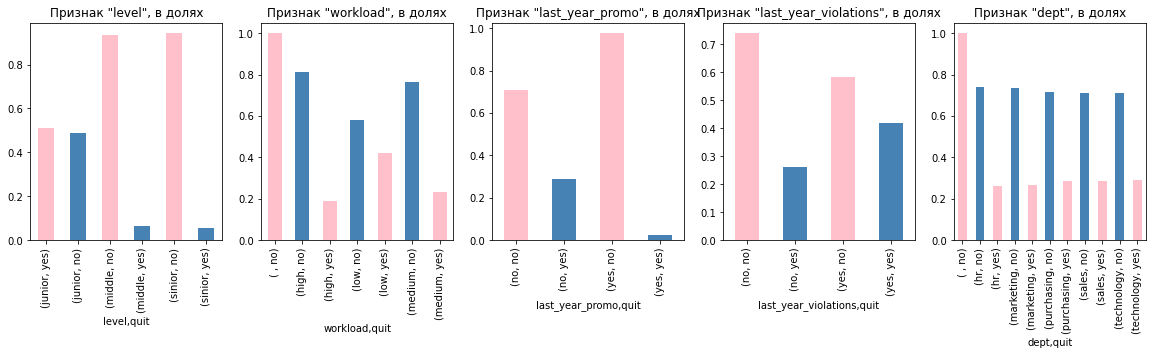

In [44]:
fig, ax = plt.subplots(1, len(ord_col+ohe_col), figsize=(20, 4))
for index, i in enumerate(ord_col+ohe_col):
    train_test2.groupby(i)['quit'].value_counts(normalize=True).plot(kind='bar', color=['pink', 'steelblue'], 
                                                                     ax = ax [index], title=f'Признак "{i}", в долях')

Чаще увольняются сотрудники начального звена (> 40%), с низким уровнем загруженности (> 40%), не получившие повышения по службе за последний год (> 90%) и не нарушавшие трудовой договор за последний год (> 40%). Доля уволившихся сотрудников в разных департаментах примерна равна и составляет от 20 до 30 %.

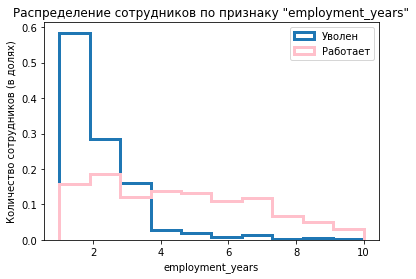

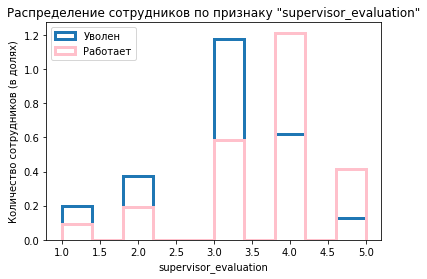

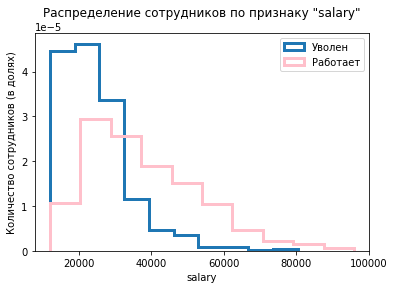

In [45]:
# распределение по количественным признакам
for i in num_сol:
    ax = train_test2[train_test2['quit']=='yes'].plot(kind='hist', y = i, histtype='step', density=True,
                                                      linewidth=3, label='Уволен', grid=True, legend=True)
    train_test2[train_test2['quit']=='no'].plot(kind='hist', y = i, histtype='step', density=True, ax=ax, 
                                                color='pink', linewidth=3, label='Работает')
    plt.title(f'Распределение сотрудников по признаку "{i}"')
    plt.xlabel(i)
    plt.ylabel('Количество сотрудников (в долях)')
    plt.show()

Чаще всего увольняются сотрудники, проработавшие меньше 3 лет в компании (employment_years), а продолжают работать сотрудники, получившие хорошие оценки качества работы (4-5 по 5-бальной шкале) от руководителя (supervisor_evaluation). Высокая доля уволившихся сотрудников с ежемесячной зарплатой ниже 20 000 у.е., и практически нет уволившихся сотрудников с ежемесячной зарплатой выше 80 000 у.е.

Таким образом, увольнение возможно, если:
- сотрудник нарушает условия трудового договора за последний год,
- является сотрудником среднего или высшего звена с высокой или средней загруженностью на работе,
- проработал в компании менее 3-х лет;
- получил низкие оценки качества работы (3 и менее) от руководителя;
- получает менее 20 000 у.е.

Сравним распределение уровня удовлетворённости сотрудников работой в компании (job_satisfaction_rate) для ушедших и оставшихся сотрудников

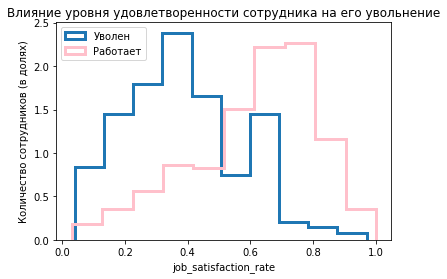

In [46]:
df = test2.merge(test_target, on = 'id', how = 'inner')
ax = df[df['quit']=='yes'].plot(kind='hist', y = 'job_satisfaction_rate', histtype='step', density=True,
                                                      linewidth=3, label='Уволен', grid=True, legend=True)
df[df['quit']=='no'].plot(kind='hist', y = 'job_satisfaction_rate', histtype='step', density=True, ax=ax, 
                                                color='pink', linewidth=3, label='Работает')
plt.title ('Влияние уровня удовлетворенности сотрудника на его увольнение')
plt.xlabel('job_satisfaction_rate')
plt.ylabel('Количество сотрудников (в долях)')
plt.show()

Предположение аналитиков подтвердилось - уровень удовлетворённости сотрудника работой в компании действительно влияет на то, уволится ли он: чем ниже уровень удовлетворенности, тем выше вероятность увольнения.

### Подготовка данных и добавление нового признака.

In [47]:
# добавим признак удовлетворенности сотрудников "job_satisfaction_rate", предсказанный лучшей моделью первой задачи:
train2 ['job_satisfaction_rate'] = grid_linal.predict(train2)
test2 ['job_satisfaction_rate'] = grid_linal.predict(test2)

/opt/conda/lib/python3.9/site-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [2] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


In [48]:
# обновим список числовых признаков с учетом вновь добавленных
num_сol = ['employment_years', 'supervisor_evaluation', 'salary', 'job_satisfaction_rate']

In [49]:
# выделим из тренировочной и тестовой входные признаки и целевой признак:
X_train2 = train2.drop(['quit', 'id'], axis = 1)
y_train2 = train2['quit']
X_test2 = test2.drop(['quit', 'id'], axis = 1)
y_test2 = test2['quit']

In [50]:
# закодируем целевой признак
# 0 - Работает
# 1 - Уволен
label_encoder  = LabelEncoder ()
y_train2 = label_encoder.fit_transform(y_train2)
y_test2 = label_encoder.transform(y_test2)

### Обучение моделей.

Для предсказания увольнения сотрудников обучим четыре модели: KNeighborsClassifier(), DecisionTreeClassifier(), LogisticRegression() и  SVC() и выберем лучшую из них. 

In [51]:
# создаём итоговый пайплайн: подготовка данных и модель
pipe_class = Pipeline([
    ('preprocessor', data_preprocessor),
    ('models', DecisionTreeClassifier(random_state=RANDOM_STATE))
])

param_grid_class = [
    # словарь для модели DecisionTreeClassifier()
    {
        'models': [DecisionTreeClassifier(random_state=RANDOM_STATE)],
        'models__max_depth': range(4, 12),
        'models__max_features': range(2, 8),
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), RobustScaler(), 'passthrough']  
    },
    # словарь для модели KNeighborsClassifier() 
    {
        'models': [KNeighborsClassifier()],
        'models__n_neighbors': range(2, 8),
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), RobustScaler(), 'passthrough']   
    },
    # словарь для модели LogisticRegression()
    {
        'models': [LogisticRegression(
            random_state=RANDOM_STATE, 
            solver='liblinear', 
            penalty='l1'
        )],
        'models__C': range(1, 8),
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), RobustScaler(), 'passthrough']  
    },
    # словарь для модели SVC()
    {
        'models': [SVC(random_state=RANDOM_STATE, kernel = 'poly', probability=True)],
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), RobustScaler(), 'passthrough']  

    }
]

In [52]:
# определяем лучшую модель и ее параметры:
grid_class = GridSearchCV(
    pipe_class, 
    param_grid_class, 
    cv=5,
    scoring= 'roc_auc',
    #random_state=RANDOM_STATE,
    n_jobs=-1
)
grid_class.fit(X_train2, y_train2)

print('Лучшая модель и её параметры:\n\n', grid_class.best_estimator_)
print ('Метрика лучшей модели на тренировочной выборке:', grid_class.best_score_)

# проверьте работу модели на тестовой выборке
# рассчитайте прогноз на тестовых данных
y_test_pred = grid_class.predict(X_test2)
probabilities = grid_class.predict_proba(X_test2)
probabilities_one = probabilities[:, 1]
print(f'Площадь ROC-кривой: {roc_auc_score(y_test2, probabilities_one)}');

Лучшая модель и её параметры:

 Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('ohe',
                                                  Pipeline(steps=[('simpleImputer_ohe',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('ohe',
                                                                   OneHotEncoder(drop='first',
                                                                                 handle_unknown='ignore'))]),
                                                  ['last_year_promo',
                                                   'last_year_violations',
                                                   'dept']),
                                                 ('ord',
                                                  Pipeline(steps=[('simpleImput

/opt/conda/lib/python3.9/site-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [2] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/opt/conda/lib/python3.9/site-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [2] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


In [53]:
# топ-10 лучших моделей:
pd.set_option('display.max_colwidth', 300)
pd.DataFrame(grid_class.cv_results_)[
    ['rank_test_score', 'param_models', 'mean_test_score','params']
].sort_values('rank_test_score').head(10)


,rank_test_score,param_models,mean_test_score,params
212,1,KNeighborsClassifier(),0.922505,"{'models': KNeighborsClassifier(), 'models__n_neighbors': 7, 'preprocessor__num': StandardScaler()}"
67,2,DecisionTreeClassifier(random_state=42),0.921469,"{'models': DecisionTreeClassifier(random_state=42), 'models__max_depth': 6, 'models__max_features': 6, 'preprocessor__num': 'passthrough'}"
65,2,DecisionTreeClassifier(random_state=42),0.921469,"{'models': DecisionTreeClassifier(random_state=42), 'models__max_depth': 6, 'models__max_features': 6, 'preprocessor__num': MinMaxScaler()}"
66,4,DecisionTreeClassifier(random_state=42),0.921449,"{'models': DecisionTreeClassifier(random_state=42), 'models__max_depth': 6, 'models__max_features': 6, 'preprocessor__num': RobustScaler()}"
64,4,DecisionTreeClassifier(random_state=42),0.921449,"{'models': DecisionTreeClassifier(random_state=42), 'models__max_depth': 6, 'models__max_features': 6, 'preprocessor__num': StandardScaler()}"
214,6,KNeighborsClassifier(),0.920452,"{'models': KNeighborsClassifier(), 'models__n_neighbors': 7, 'preprocessor__num': RobustScaler()}"
244,7,"SVC(kernel='poly', probability=True, random_state=42)",0.919886,"{'models': SVC(kernel='poly', probability=True, random_state=42), 'preprocessor__num': StandardScaler()}"
208,8,KNeighborsClassifier(),0.919566,"{'models': KNeighborsClassifier(), 'models__n_neighbors': 6, 'preprocessor__num': StandardScaler()}"
43,9,DecisionTreeClassifier(random_state=42),0.918902,"{'models': DecisionTreeClassifier(random_state=42), 'models__max_depth': 5, 'models__max_features': 6, 'preprocessor__num': 'passthrough'}"
42,9,DecisionTreeClassifier(random_state=42),0.918902,"{'models': DecisionTreeClassifier(random_state=42), 'models__max_depth': 5, 'models__max_features': 6, 'preprocessor__num': RobustScaler()}"


### Вывод о модели вероятности увольнения сотрудника.

Лучшие показатели прогнозирования вероятности увольнения сотрудников - у модели 7 ближайших соседей, которая имеет наилучшую метрику качества roc_auc_score на тренировочных данных = 0.9225, на тестовых = 0.9103.

## Общий вывод.

**Исходные данные**, предоставленные компанией «Работа с заботой» содержат информацию о 6000 сотрудниках, в том числе об отделе, в котором они работают, уровне занимаемой должности, уровне загруженности, длительность работы в компании (в годах), повышениях за последний год, нарушениях трудового договора за последний год, оценках качества работы руководителем, ежемесячной зарплате, а также 2 целевых признака - уровень удовлетворенности сотрудника работой в компании и статус увольнения. Данные досточно высокого качества, присутствует лишь незначительные пропуски в признаках, характеризующих отдел, уровень занимаемой должности и уровень загруженности у 5 сотрудников.

**Цель исследования**: для снижения расходов компании на поиск и обучение новых сотрудников в результате уменьшения оттока действующих сотрудников разработать 2 модели машинного обучения:
1. Для определения уровня удовлетворённости сотрудников работой в компании.
2. Для предсказания увольнения сотрудников.

Исследовательский анализ данных всех сотрудников выявил, что:

- сотрудники работают в компании от года до 10 лет, в среднем длительность работы в компании (employment_years) составляет 3,7 года;
- средняя оценка качества работы сотрудников руководителем (supervisor_evaluation) равна 3,5 по 5-балльной шкале;
- средняя зарплата (salary) сотрудников составляет около 34 тыс.руб. (от 12 тыс. руб. до 98 400 тыс. руб.), при этом половина сотрудников получает 30 тыс.руб. и менее, 25 % сотрудников получают 43,2 тыс. руб. и выше;
- большая часть сотрудников (38%) работают в отделе продаж, на втором месте (22%) - IT;
- больше всего сотрудников на позиции junior (48%), сотрудников среднего звена - 43% и старших сотрудников - 9%;
- 52 % сотрудников имеют средний уровень загруженности (workload), 30% - низкую и 18% - высокую;
- повышение за последний год (last_year_promo) получили 3 % сотрудников;
- 14% сотрудников нарушали трудовой договор за последний год.

Анализ взамосвязей данных выявил, что на целевой признак 'Уровень удовлетворённости сотрудника работой в компании':
- наибольшее влияние оказывает оценка качества работы сотрудника, которую дал руководитель (supervisor_evaluation), 
- также заметное влияние оказывают нарушения сотрудниками трудового договора (last_year_violations) и длительность работы в компании (employment_years);
- слабое влияние на уровнень удовлетворённости сотрудников имеют размер ежемесячной зарплаты (salary) и повышения за последний год (last_year_promo),
- практически не влияют на уровень удовлетворённости сотрудников уровень их загруженности (workload), отдел, в котором они работают, (dept) и уровень занимаемой должности (level). 

***Модель № 1:***
для предсказания уровня удовлетворённости сотрудника работой в компании проведено обучение 2 разных моделей машинного обучения с разными параметрами (LinearRegression() и DecisionTreeRegressor()), в результате которого лучший результат по метрике SMAPE показала модель дерева регрессии с глубиной = 11 и 10 учитываемыми признаками. 

Анализ сотрудников в зависимости от статуса их трудоустройства показал, что:
- около 30 % сотрудников увольняется;
- доля сотрудников, нарушавших условия трудового договора за последний год, среди уволившихся сотрудников меньше;
- сотрудники среднего (middle) и высшего (sinior) звена увольняются гораздо чаще, чем сотрудники с маленьким опытом (junior);
- доля уволившихся сотрудников с высоким и средним уровнем загруженности (workload) на работе выше, чем у слабозагруженных сотрудников;
- чаще всего увольняются сотрудники, проработавшие меньше 3 лет в компании (employment_years), а продолжают работать сотрудники, получившие хорошие оценки качества работы (4-5 по 5-бальной шкале) от руководителя (supervisor_evaluation);
- высокая доля уволившихся сотрудников с ежемесячной зарплатой ниже 20 000 у.е., и практически нет уволившихся сотрудников с ежемесячной зарплатой выше 80 000 у.е.;
- показатель уровеня удовлетворённости сотрудника работой в компании влияет на то, уволится ли он: чем ниже уровень удовлетворенности, тем выше вероятность увольнения. 

***Модель № 2:***
для предсказания вероятности увольнения сотрудника проведено обучение 4 разных моделей машинного обучения с разными параметрами (KNeighborsClassifier(), DecisionTreeClassifier(), LogisticRegression() и SVC()), в результате которого лучший результат по метрике качества roc_auc_score на тренировочных данных показала модель 7 ближайших соседей (0.9225), на тестовых roc_auc_score составила 0.9103.  


На основании проведенного ислледования ***рекомендуем***:

1. Несмотря на достаточное высокое качество предоставленных данных (отсутствие дубликатов и высокая заполненность данных), усилить контроль за заполнением в целях исключения пропусков и нестандартных значений в данных.
2. Использовать обученую модель дерева регрессии для прогнозирования уровня удовлетворённости сотрудников работой в компании для разработки внутрикорпоративного протокола повышения корпоративного духа.
3. Использовать обученую модель ближайших соседей для прогнозирования увольнения ценных сотрудников для подготовки персональных предложений и снижения расходов компании в результате их оттока.
4. Пересмотреть распределение нагрузки между сотрудниками для ее выравнивания.
5. Внедрить систему стимулирующих выплат и/или нематериальных благ за хорошие показатели качества работы, для увеличения заинтересованности сотрудников в их достижении. 
5. В случае появления новых признаков либо существенных изменений в данных текущих признаков обратиться за обновлением моделей машинного обучения.